In [46]:
# Importation des bibliothèques requises
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Flatten, Dense
import tensorflow as tf
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
# Configure TensorFlow to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [48]:
imageSize = 150
train_dir = "./Data/oct2017/OCT2017_/train/"
test_dir = "./Data/oct2017/OCT2017_/test/"


def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            label = (
                ["NORMAL", "CNV", "DME", "DRUSEN"].index(folderName)
                if folderName in ["NORMAL", "CNV", "DME", "DRUSEN"]
                else 4
            )
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + "/" + image_filename)
                if img_file is not None:
                    img_file = resize(img_file, (imageSize, imageSize, 3))
                    X.append(np.asarray(img_file))
                    y.append(label)
    return np.asarray(X), np.asarray(y)

In [49]:
# Uncomment the following line to use the full dataset
# X_train, y_train = get_data(train_dir)
X_test, y_test = get_data(test_dir)

X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2)

y_trainHot = to_categorical(y_train, num_classes=4)
y_testHot = to_categorical(y_test, num_classes=4)

100%|██████████| 243/243 [00:05<00:00, 42.06it/s]


In [50]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [51]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    metrics = np.load("logs.npy", allow_pickle=True).item()
    filt = ["acc"]
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(
            l, c="r" if "val" not in k else "b", label="val" if "val" in k else "train"
        )
        x = np.argmin(l) if "loss" in k else np.argmax(l)
        y = l[x]
        plt.scatter(x, y, lw=0, alpha=0.25, s=100, c="r" if "val" not in k else "b")
        plt.text(
            x,
            y,
            "{} = {:.4f}".format(x, y),
            size="15",
            color="r" if "val" not in k else "b",
        )
    plt.legend(loc=4)
    plt.grid()
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")

In [52]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [53]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["train", "test"], loc="upper left")

In [54]:
map_characters = {0: "Normal", 1: "CNV", 2: "DME", 3: "DRUSEN"}
class_weight1 = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)

weight_path1 = "./Pretrained Models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
weight_path2 = (
    "./Pretrained Models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
)
pretrained_model_1 = VGG16(
    weights=weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3)
)
pretrained_model_2 = InceptionV3(
    weights=weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3)
)
optimizer1 = tf.keras.optimizers.Adam()
optimizer2 = tf.keras.optimizers.RMSprop(lr=0.0001)

c:\Users\axela\anaconda3\envs\work-env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [55]:
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, pretrainedweights, classweight, numclasses, numepochs, optimizer, labels):
    base_model = pretrainedmodel
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
    model.summary()

    history = model.fit(xtrain, ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest, ytest), verbose=1, callbacks=[MetricsCheckpoint('logs')])

    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(ytest, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes=list(labels.values()))
    plt.show()
    return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

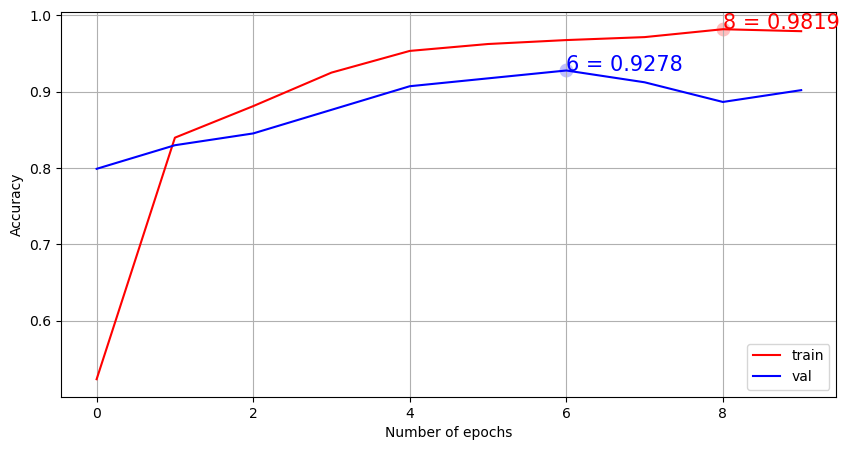

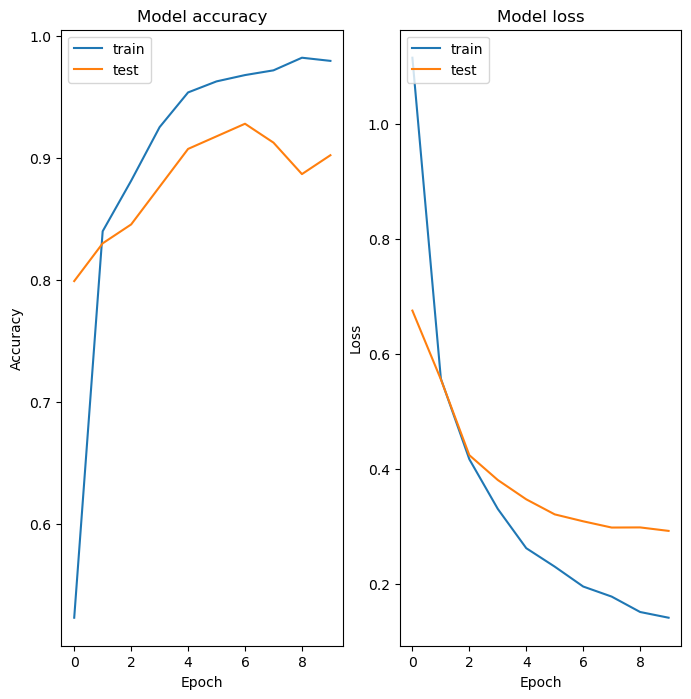

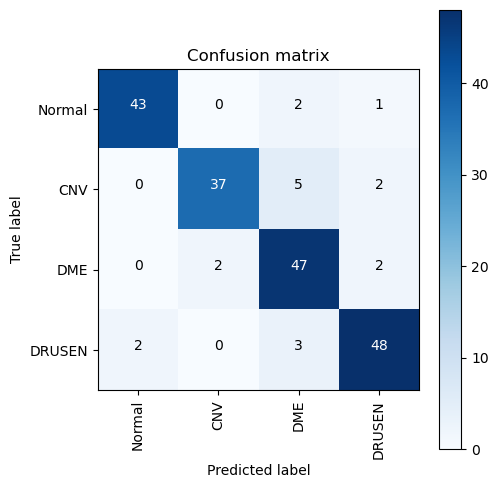

In [56]:
# Un-comment to use the following lines to train and evaluate the model
# VGG16_model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_1, weight_path1, class_weight1, 4, 10, optimizer1, map_characters)



class_weight_dict = dict(enumerate(class_weight1))
VGG16_model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_1, weight_path1, class_weight_dict, 4, 10, optimizer1, map_characters)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

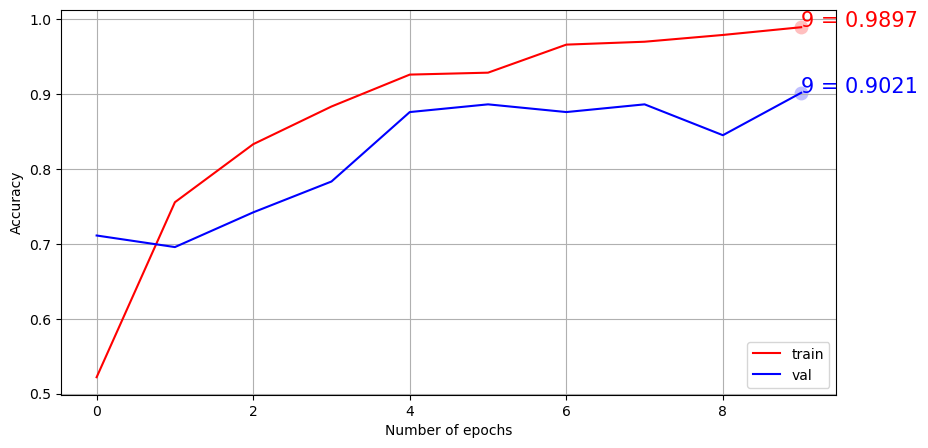

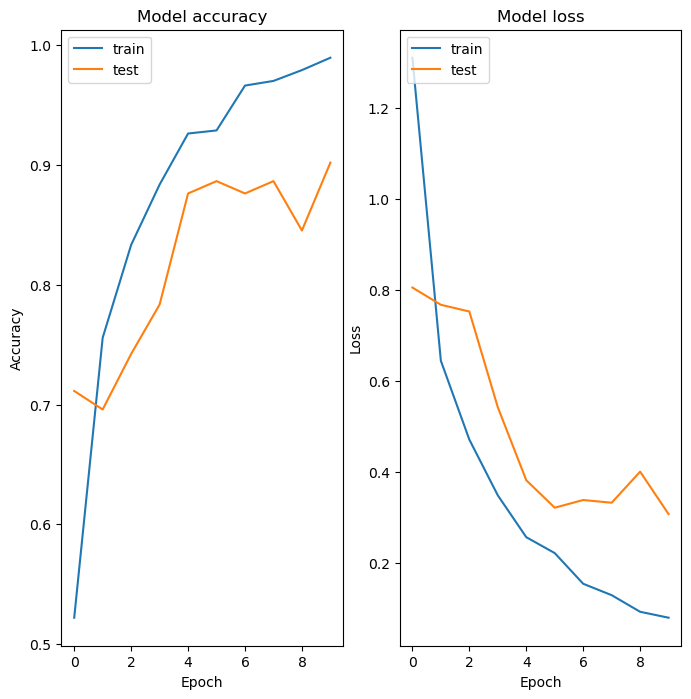

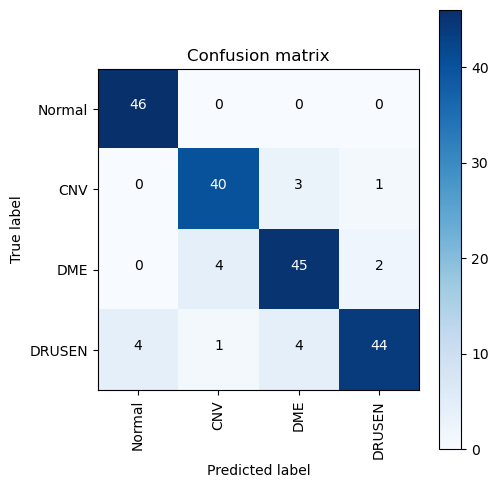

In [58]:
# Un-comment to use the following lines to train and evaluate the model
class_weight_dict = dict(enumerate(class_weight1))
InceptionV3_model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_2, weight_path2, class_weight_dict, 4, 10, optimizer2, map_characters)

In [59]:
# model.save("model-classification-maladie-retine.h5")
VGG16_model.save("VGG16-model-classification-maladie-retine.h5")
InceptionV3_model.save("InceptionV3-model-classification-maladie-retine.h5")